In [3]:
import seaborn as sns
import tensorflow
import pandas as pd

# 1. Formulate / outline the problem

In this episode we will be using the penguin dataset. This is a dataset that was published in 2020 by Allison Horst and contains data on three different species of the penguins.

We will use the penguin dataset to train a neural network which can classify which species a penguin belongs to, based on their physical characteristics.

The palmerpenguins data contains size measurements for three penguin species observed on three islands in the Palmer Archipelago, Antarctica. The physical attributes measured are flipper length, beak length, beak width, body mass, and sex.

These data were collected from 2007 - 2009 by Dr. Kristen Gorman with the Palmer Station Long Term Ecological Research Program, part of the US Long Term Ecological Research Network. The data were imported directly from the Environmental Data Initiative (EDI) Data Portal, and are available for use by CC0 license (“No Rights Reserved”) in accordance with the Palmer Station Data Policy.

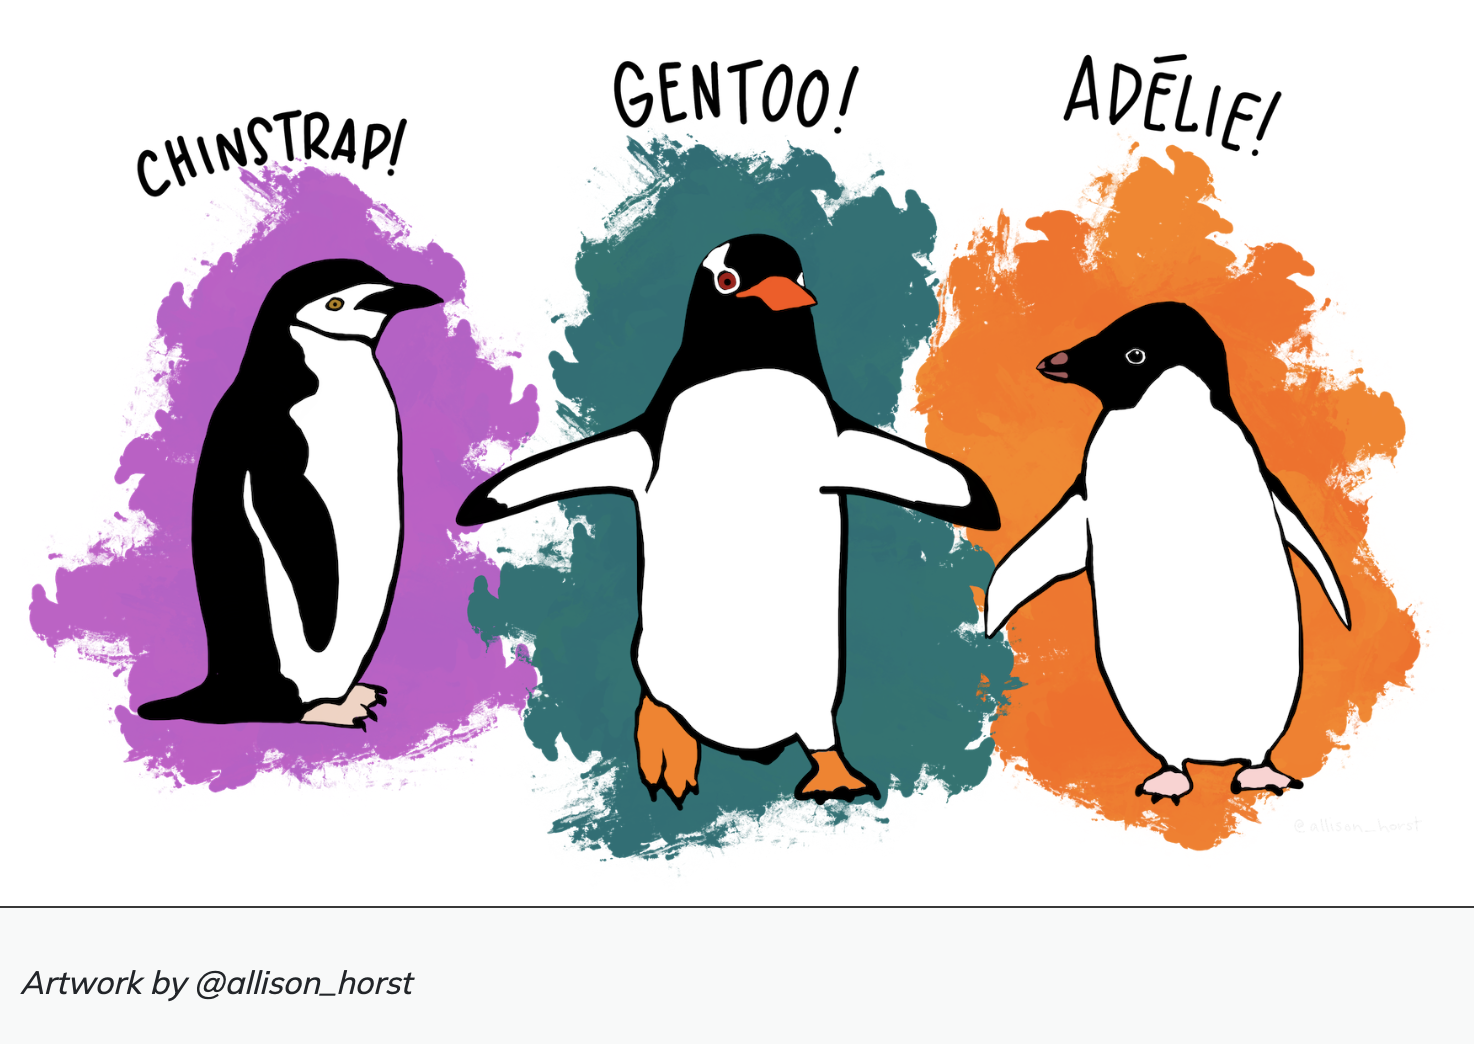

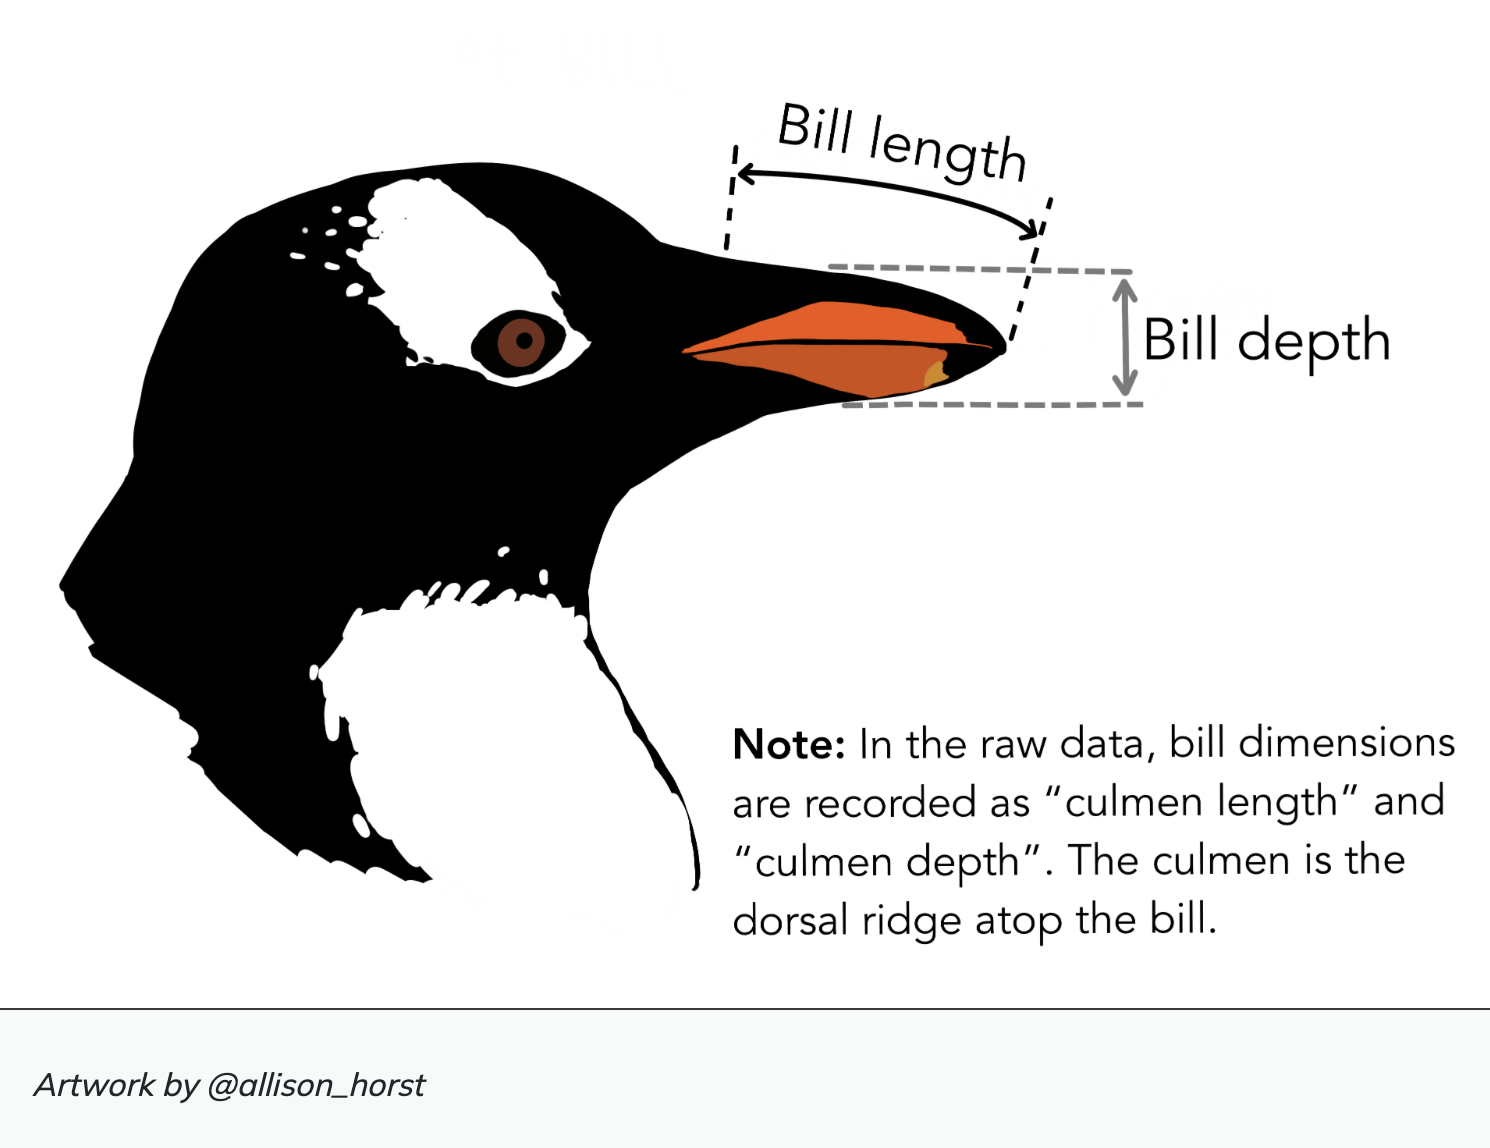

# 2. Identify inputs and outputs

In [9]:
# Load the data
penguins = sns.load_dataset('penguins')

In [10]:
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female


In [11]:
penguins.shape

(344, 7)

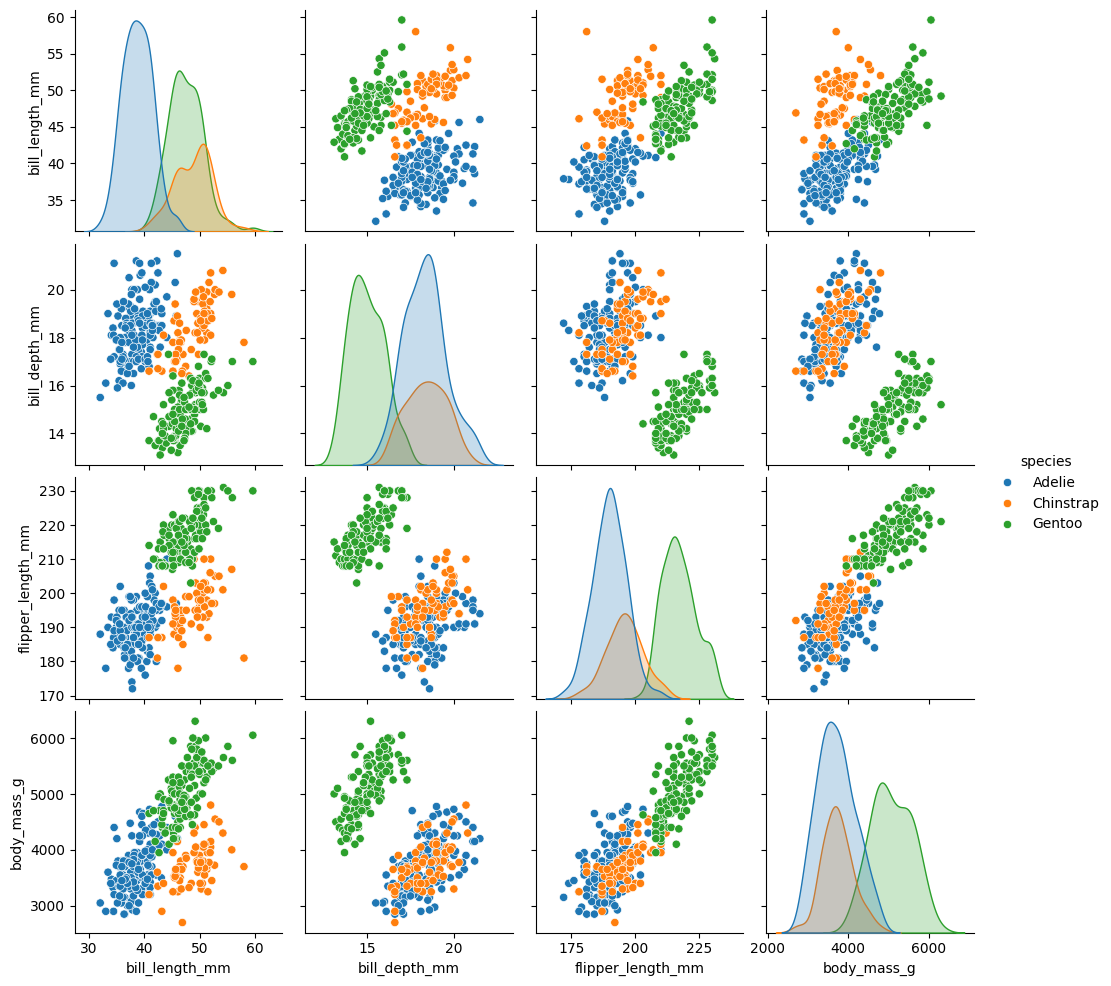

In [12]:
# Visulualise the data using a pairplot
sns.pairplot(penguins, hue='species')

# 3. Prepare data

In [8]:
# We will only use the numerical values here, so we drop the categorical columns
penguins_filtered = penguins.drop(columns=['island', 'sex'])

In [13]:
# Drop the rows that have NaN values in them
penguins_filtered = penguins_filtered.dropna()

In [11]:
penguins_filtered

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,Adelie,39.1,18.7,181.0,3750.0
1,Adelie,39.5,17.4,186.0,3800.0
2,Adelie,40.3,18.0,195.0,3250.0
4,Adelie,36.7,19.3,193.0,3450.0
5,Adelie,39.3,20.6,190.0,3650.0
...,...,...,...,...,...
338,Gentoo,47.2,13.7,214.0,4925.0
340,Gentoo,46.8,14.3,215.0,4850.0
341,Gentoo,50.4,15.7,222.0,5750.0
342,Gentoo,45.2,14.8,212.0,5200.0


In [14]:
# Extract columns corresponding to features
features = penguins_filtered.drop(columns=['species'])

In [15]:
# Convert the target string values (penguin names) into numerical values that can be handled by the model using one-hot-encoding
target = pd.get_dummies(penguins_filtered['species'])

In [16]:
# Split the data into training and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    features,
    target,
    test_size=0.2,
    random_state=0,
    shuffle=True,
    stratify=target
)

# 4. Build an architecture from scratch or choose a pretrained model
We will now build a simple neural network from scratch using Keras.

With Keras you compose a neural network by creating layers and linking them together. For now we will only use one type of layer called a fully connected or Dense layer. In Keras this is defined by the keras.layers.Dense class.

A dense layer has a number of neurons, which is a parameter you can choose when you create the layer. When connecting the layer to its input and output layers every neuron in the dense layer gets an edge (i.e. connection) to all of the input neurons and all of the output neurons. The hidden layer in the image in the introduction of this episode is a Dense layer.

The input in Keras also gets special treatment, Keras automatically calculates the number of inputs and outputs a layer needs and therefore how many edges need to be created. This means we need to inform Keras how big our input is going to be. We do this by instantiating a keras.Input class and tell it how big our input is, thus the number of columns it contains.

In [29]:
from tensorflow import keras

In [30]:
from numpy.random import seed

seed(1)

In [31]:
keras.utils.set_random_seed(2)

In [32]:
inputs = keras.Input(shape=(X_train.shape[1],))

In [33]:
# Create a hidden layer consisting of 10 neurons and using the activation function called relu
hidden_layer = keras.layers.Dense(10, activation="relu")(inputs)

In [34]:
# Create a dense output layer consisting of 3 neurons (one for each class - penguin species), using the softmax activation function
output_layer = keras.layers.Dense(3, activation="softmax")(hidden_layer)

In [35]:
# Combine the different layers into a model
model = keras.Model(inputs=inputs, outputs=output_layer)

# Show some information about the model we have defined
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense_3 (Dense)             (None, 10)                50        
                                                                 
 dense_4 (Dense)             (None, 3)                 33        
                                                                 
Total params: 83 (332.00 Byte)
Trainable params: 83 (332.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 5. Choose a loss function and optimizer
We have now designed a neural network that in theory we should be able to train to classify Penguins. However, we first need to select an appropriate loss function that we will use during training. This loss function tells the training algorithm how wrong, or how ‘far away’ from the true value the predicted value is.

For the one-hot encoding that we selected earlier a suitable loss function is the Categorical Crossentropy loss. In Keras this is implemented in the keras.losses.CategoricalCrossentropy class. This loss function works well in combination with the softmax activation function we chose earlier. The Categorical Crossentropy works by comparing the probabilities that the neural network predicts with ‘true’ probabilities that we generated using the one-hot encoding. This is a measure for how close the distribution of the three neural network outputs corresponds to the distribution of the three values in the one-hot encoding. It is lower if the distributions are more similar.

For more information on the available loss functions in Keras you can check the [documentation](https://www.tensorflow.org/api_docs/python/tf/keras/losses).

Next we need to choose which optimizer to use and, if this optimizer has parameters, what values to use for those. Furthermore, we need to specify how many times to show the training samples to the optimizer.

Once more, Keras gives us plenty of choices all of which have their own pros and cons, but for now let us go with the widely used [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer. Adam has a number of parameters, but the default values work well for most problems. So we will use it with its default parameters.

Combining this with the loss function we decided on earlier we can now compile the model using model.compile. Compiling the model prepares it to start the training.

In [36]:
model.compile(
    optimizer='adam',
    loss=keras.losses.CategoricalCrossentropy()
    )

# 6. Train model
Training the model is done using the fit method, it takes the input data and target data as inputs and it has several other parameters for certain options of the training. Here we only set a different number of epochs. One training epoch means that every sample in the training data has been shown to the neural network and used to update its parameters.

In [37]:
history = model.fit(X_train, y_train, epochs=100)

Epoch 1/100
9/9 [==============================] - 0s 804us/step - loss: 623.0574
Epoch 2/100
9/9 [==============================] - 0s 632us/step - loss: 516.2007
Epoch 3/100
9/9 [==============================] - 0s 636us/step - loss: 408.5740
Epoch 4/100
9/9 [==============================] - 0s 550us/step - loss: 300.2234
Epoch 5/100
9/9 [==============================] - 0s 647us/step - loss: 199.2896
Epoch 6/100
9/9 [==============================] - 0s 645us/step - loss: 122.2795
Epoch 7/100
9/9 [==============================] - 0s 651us/step - loss: 49.2803
Epoch 8/100
9/9 [==============================] - 0s 611us/step - loss: 29.0868
Epoch 9/100
9/9 [==============================] - 0s 680us/step - loss: 18.6026
Epoch 10/100
9/9 [==============================] - 0s 573us/step - loss: 17.2274
Epoch 11/100
9/9 [==============================] - 0s 562us/step - loss: 15.3039
Epoch 12/100
9/9 [==============================] - 0s 533us/step - loss: 15.1360
Epoch 13/100
9/9 [=

<Axes: >

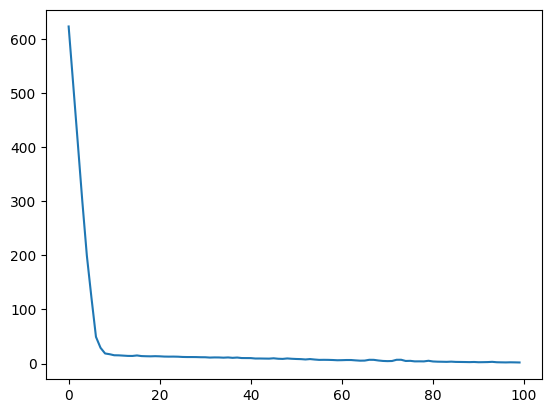

In [38]:
# Plot the loss as function of training epochs
sns.lineplot(x=history.epoch, y=history.history['loss'])

# 7. Perform a prediction/classification

In [39]:
# Predict penguin species for the test data
y_pred = model.predict(X_test)

3/3 [==============================] - 0s 912us/step


In [42]:
# Convert the predictions into a pandas dataframe for convenience
prediction = pd.DataFrame(y_pred, columns=target.columns)
prediction

,Adelie,Chinstrap,Gentoo
0,0.999709,1.504898e-06,0.000290
1,0.967634,3.437196e-03,0.028929
2,0.999677,3.814366e-05,0.000285
3,0.601159,2.608959e-04,0.398580
4,0.259414,5.409651e-03,0.735177
...,...,...,...
64,0.045923,7.437029e-01,0.210374
65,0.444420,4.564891e-01,0.099091
66,0.039467,4.437438e-02,0.916158
67,0.779402,1.861350e-05,0.220580


Remember that the output of the network uses the softmax activation function and has three outputs, one for each species. This dataframe shows this nicely.

We now need to transform this output to one penguin species per sample. We can do this by looking for the index of highest valued output and converting that to the corresponding species. Pandas dataframes have the idxmax function, which will do exactly that.

In [53]:
# Convert the numerical predictions into one predicted penguin species name
prediction_species = prediction.idxmax(axis="columns")
prediction_species

0        Adelie
1        Adelie
2        Adelie
3        Adelie
4        Gentoo
        ...    
64    Chinstrap
65    Chinstrap
66       Gentoo
67       Adelie
68       Adelie
Length: 69, dtype: object

# 8. Measuring performance
Now that we have a trained neural network it is important to assess how well it performs. We want to know how well it will perform in a realistic prediction scenario, measuring performance will also come back when refining the model.

We have created a test set (i.e. y_test) during the data preparation stage which we will use now to create a confusion matrix.

## Confusion matrix
With the predicted species we can now create a confusion matrix and display it using seaborn.

A confusion matrix is an N x N matrix used for evaluating the performance of a classification model, where N is the number of target classes. The matrix compares the actual target values with those predicted from the classification model, which gives a holistic view of how well the classification model is performing.

In [43]:
from sklearn.metrics import confusion_matrix

In [52]:
# Convert the labels from the test data set into the same format as the predicted values
true_species = y_test.idxmax(axis="columns")

In [46]:
matrix = confusion_matrix(true_species, prediction_species)

In [47]:
# Convert into a pandas dataframe
confusion_df = pd.DataFrame(matrix, index=y_test.columns.values, columns=y_test.columns.values)
confusion_df.columns.name = 'Predicted Label'
confusion_df.index.name = 'True label'
confusion_df

Predicted Label,Adelie,Chinstrap,Gentoo
True label,,,
Adelie,18,10,2
Chinstrap,0,0,14
Gentoo,18,0,7


<Axes: xlabel='Predicted Label', ylabel='True label'>

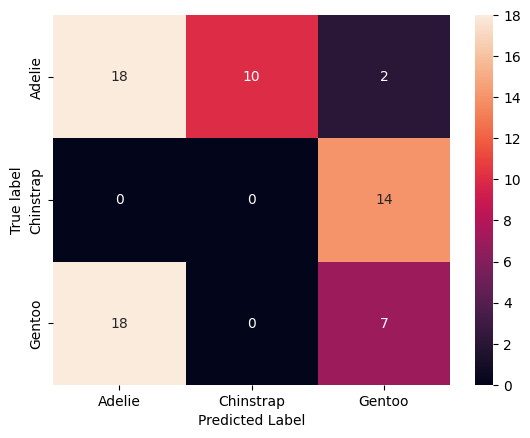

In [48]:
# Visualise the confusion matrix as a heatmap
sns.heatmap(confusion_df, annot=True)

# 9. Refine the model
As we discussed before the design and training of a neural network comes with many hyperparameter and model architecture choices. We will go into more depth of these choices in later episodes. For now it is important to realize that the parameters we chose were somewhat arbitrary and more careful consideration needs to be taken to pick hyperparameter values.

# 10. Share model

In [49]:
# Save the model
model.save('my_first_model.keras')

In [50]:
# Reload the saved model
pretrained_model = keras.models.load_model('my_first_model.keras')

In [51]:
# Make a prediction with the loaded model
y_pretrained_pred = pretrained_model.predict(X_test)

3/3 [==============================] - 0s 1ms/step


In [43]:
pretrained_prediction = pd.DataFrame(y_pretrained_pred, columns=target.columns.values)

In [44]:
pretrained_predicted_species = pretrained_prediction.idxmax(axis="columns")

In [45]:
pretrained_predicted_species

0        Adelie
1        Adelie
2        Adelie
3        Adelie
4        Gentoo
        ...    
64    Chinstrap
65    Chinstrap
66       Gentoo
67       Adelie
68       Adelie
Length: 69, dtype: object

# Key points

- The deep learning workflow is a useful tool to structure your approach, it helps to make sure you do not forget any important steps.
- Exploring the data is an important step to familiarize yourself with the problem and to help you determine the relavent inputs and outputs.
- One-hot encoding is a preprocessing step to prepare labels for classification in Keras.
- A fully connected layer is a layer which has connections to all neurons in the previous and subsequent layers.
- keras.layers.Dense is an implementation of a fully connected layer, you can set the number of neurons in the layer and the activation function used.
- To train a neural network with Keras we need to first define the network using layers and the Model class. Then we can train it using the model.fit function.
- Plotting the loss curve can be used to identify and troubleshoot the training process.
- The loss curve on the training set does not provide any information on how well a network performs in a real setting.
- Creating a confusion matrix with results from a test set gives better insight into the network’s performance.